In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
#from sklearn_extra.cluster import KMedoids # pip install scikit-learn-extra

import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates



In [3]:
data = pd.read_csv('data.csv', delimiter=';')

## Scaling

In [4]:
# Select the relevant columns for clustering
features = ['RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2', 'RS_E_OilPress_PC1',
            'RS_E_OilPress_PC2', 'RS_E_RPM_PC1', 'RS_E_RPM_PC2', 'RS_E_WatTemp_PC1',
            'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC1', 'RS_T_OilTemp_PC2', 'temperature',
            'precipitation', 'windspeed_10m', 'sum_pollen']


# drop timestamp feature
#data = data.drop(columns=['timestamps_UTC'])

# Extract the selected features from the DataFrame
X = data[features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## K-means

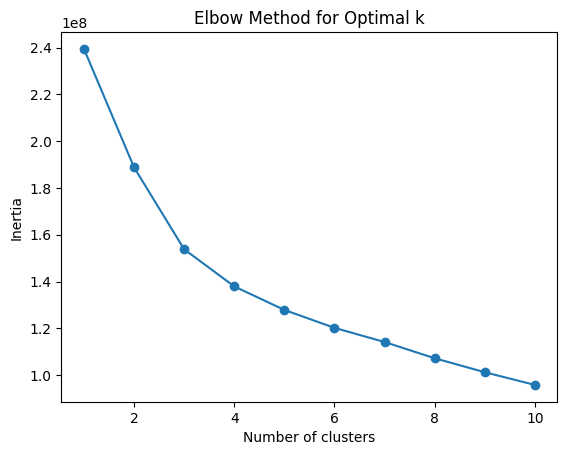

In [5]:
# Find the optimal number of clusters using the Elbow method


inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()



In [6]:
# Choose an appropriate number of clusters (k) based on the Elbow curve
k = 5  # Adjust this value based on the Elbow curve

# Fit the K-means model
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(X_scaled)


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5, random_state=0)

In [7]:
# Add cluster labels to the original DataFrame
data['cluster'] = kmeans.labels_

# Calculate the distance of each point to its assigned cluster center
data['distance_to_center'] = np.min(kmeans.transform(X_scaled), axis=1)

In [9]:
max_temp_air = 65
max_temp_water = 100
max_temp_oil = 115

min_temp = 2

# Get cluster centroids
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Create a DataFrame to hold the cluster centroids
cluster_centroids_df = pd.DataFrame(cluster_centers, columns=features)

# Define acceptable ranges for each feature
acceptable_ranges = {
    'RS_E_InAirTemp_PC1': (min_temp, max_temp_air),
    'RS_E_InAirTemp_PC2': (min_temp, max_temp_air),
    'RS_E_WatTemp_PC1': (min_temp, max_temp_water),
    'RS_E_WatTemp_PC2': (min_temp, max_temp_water),
    'RS_T_OilTemp_PC1': (min_temp, max_temp_oil),
    'RS_T_OilTemp_PC2': (min_temp, max_temp_oil),
}

# Check for clusters with centroids outside acceptable ranges
abnormal_clusters = []
for cluster_idx, centroid in enumerate(cluster_centers):
    is_abnormal = False
    for feature, (min_value, max_value) in acceptable_ranges.items():
        if centroid[features.index(feature)] < min_value or centroid[features.index(feature)] > max_value:
            is_abnormal = True
            break
    if is_abnormal:
        abnormal_clusters.append(cluster_idx)

abnormal_clusters

[]

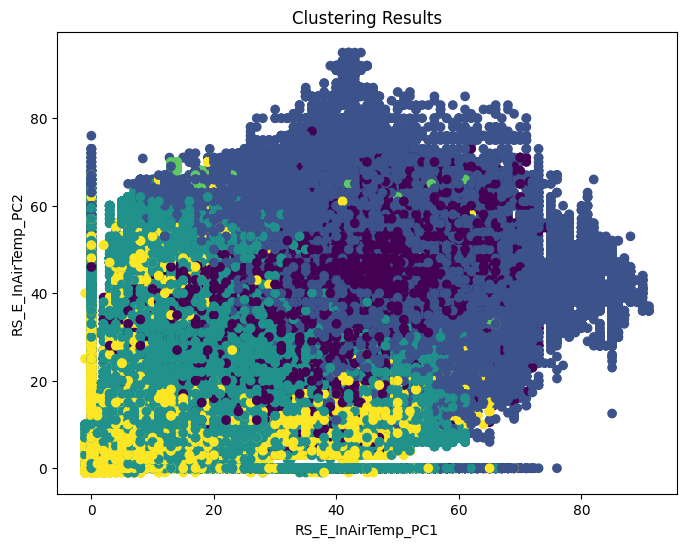

In [10]:
feature1 = 'RS_E_InAirTemp_PC1'
feature2 = 'RS_E_InAirTemp_PC2'

plt.figure(figsize=(8, 6))
plt.scatter(data[feature1], data[feature2], c=data['cluster'], cmap='viridis')
plt.title('Clustering Results')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()

Moyenne des clusters

In [11]:
means = data.groupby('cluster').mean()
means



/var/folders/fj/rsg75z_s7cq8mvy8kr0fb2ym0000gn/T/ipykernel_26013/961576103.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = data.groupby('cluster').mean()


,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,temperature,precipitation,windspeed_10m,sum_pollen,distance_to_center
cluster,,,,,,,,,,,,,,,,,,
0,151.394216,50.916298,4.284741,37.122639,37.371224,379.833160,390.640262,1566.720569,1567.436861,83.883801,83.291429,85.154171,85.131036,13.157823,0.065804,13.536811,18.228429,2.513029
1,150.739003,50.871178,4.198192,36.888132,36.759726,217.095176,219.808803,802.305223,799.967554,82.229473,81.820240,82.482985,82.413160,16.384710,0.051748,13.055456,24.043358,2.076269
2,150.809417,50.872707,4.239783,21.124781,21.541280,248.508823,259.743394,808.397506,792.641336,76.378435,74.770130,75.085300,73.979663,7.533119,0.067021,13.495772,9.601871,2.342824
3,150.536185,50.872378,4.215007,33.215896,32.995621,261.659163,259.950163,938.239978,924.211866,80.709025,79.473352,80.825309,79.965023,15.535055,2.301197,14.804814,3.415799,3.555817
4,150.469153,50.817359,4.231122,16.683026,16.722576,358.995608,367.772656,744.584818,755.266098,52.914797,52.786154,47.127619,47.017152,9.501943,0.070982,13.200873,16.194125,3.520491


In [36]:
# compute number of elements in each cluster
cluster_elements = data.groupby(['cluster', 'mapped_veh_id']).size().reset_index(name='count')
cluster_elements

,cluster,mapped_veh_id,count
0,0,102.0,31461
1,0,103.0,12993
2,0,104.0,12143
3,0,105.0,4447
4,0,106.0,21471
...,...,...,...
455,4,191.0,15948
456,4,192.0,20658
457,4,194.0,24920
458,4,196.0,88837


In [40]:
# I want to see how many times each mapped_veh_id appears in each cluster
cluster_elements = data.groupby(['cluster', 'mapped_veh_id']).size().reset_index(name='count')
# Sort the values by mapped_veh_id
cluster_elements_sorted = cluster_elements.sort_values(by=['mapped_veh_id', 'count'], ascending=True)


In [41]:
cluster_elements_sorted.to_clipboard()